# <b>Deep Learning:</b> Risiko! Army detector

---
A.A. 2022/23 (6 CFU) - Dr. Daniel Fusaro Ph.D. Student

---

# Synthetic Dataset creator


With this Jupyter Notebook you can:
 - load the 3D model (aka mesh) of either a tank or a flag
 - project it to a background image (some are an empty Risiko! board, some are downloaded from [https://www.microsoft.com/en-us/download/details.aspx?id=52644](https://www.microsoft.com/en-us/download/details.aspx?id=52644))
 - extracts the ground truth bounding box using some rendering information
 - stores to disk both the image full of armies and the labels information file
 - visualize the produced dataset
 
You can (and should) play especially with the following parameters:
 - far_plane
 - max_tanks_in_image_num
 - max_flags_in_image_num
 - img_width, img_height
 - def generate_color (object_class)
    - modify the hsv ranges if you think that the colors are not the best (ehm ehm)
 - background_folder_path
    - you may add more background images or remove some

---

 - Risiko! game official Wikipedia page -
[https://en.wikipedia.org/wiki/RisiKo!](https://en.wikipedia.org/wiki/RisiKo!)
 - HSV color space - [https://it.wikipedia.org/wiki/Hue_Saturation_Brightness](https://it.wikipedia.org/wiki/Hue_Saturation_Brightness)
 - HSV color space online visualizer - [https://math.hws.edu/graphicsbook/demos/c2/rgb-hsv.html](https://math.hws.edu/graphicsbook/demos/c2/rgb-hsv.html)


In [1]:
# install the required packages for working in Colab
%pip install open3d

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 121.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.3/138.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.4
    Uninstalling widgetsnbextension-3.6.4:
      Successfully uninstalled widgetsnbextension-3.6.4
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pi

In [2]:
# specifictions for rendering
import os
os.environ['EGL_PLATFORM'] = 'surfaceless'   # Ubuntu 20.04+
os.environ['OPEN3D_CPU_RENDERING'] = 'true'  # Ubuntu 18.04 (just in case)

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import open3d as o3d
import cv2
from tqdm import tqdm
import random
import colorsys
import copy
import gc

In [4]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# access the folder containing the files required to run the project
%cd /content/drive/My Drive/Colab environments/Risiko! DL/
# check that we are in the desired folder and that all required files are present
%ls

Mounted at /content/drive
/content/drive/My Drive/Colab environments/Risiko! DL
 3D_models/            'Risiko!_Synthetic_Dataset_Creator.ipynb'
 backgrounds/          'Risiko! Test.ipynb'
 coco_risiko.yaml       synthetic_dataset/
 pre_trained_weights/   synthetic_images/
 real_images/           test_example.txt


## Set the parameters

In [5]:
## Paths
background_folder_path = "backgrounds"
output_folder_path = "synthetic_dataset"
tank_3dmodel_path = "3D_models/Risiko_Tank_v2.stl"
flag_3dmodel_path = "3D_models/RisikoFlag.stl"
backs = [os.path.join(dp, f) for dp, dn, filenames in os.walk(background_folder_path) for f in filenames if os.path.splitext(f)[1] in [".jpg", ".JPG"]]

## General Params
images_to_gen_num = 3 #1000, set to 150 only for debugging reasons
max_tanks_in_image_num = 80
max_flags_in_image_num = 20
max_fails = 10

## Rendering Params
debug_visual = False
img_width, img_height = 1920, 1280
near_plane = 0.1
far_plane  = 1e4
v_fov      = 15.0       # vertical field of view: between 5 and 90 degrees
center     = [0, 0, 0]  # look_at target
up         = [0, 1, 0]  # camera orientation
rpy_amp    = 10         # rotation span (for randomly drawing)
min_eye_dist, max_eye_dist = 300, 2300
min_amp, max_amp = 30, 200
aspect_ratio = img_width / img_height  # azimuth over elevation

fov_type = o3d.visualization.rendering.Camera.FovType.Vertical


## Color macros
BLUE, RED, YELLOW, PURPLE, BLACK, GREEN = 0, 1, 2, 3, 4, 5
BACKGROUND_COLOR = [0, 0, 0, 0]


## check if out dir exists, otherwise create it
if not os.path.isdir(output_folder_path):
    os.mkdir(output_folder_path)
    print(f"created folder {output_folder_path}")

## if images and labels dirs do not exists, create them
if not os.path.isdir(f"{output_folder_path}/images"):
    os.mkdir(f"{output_folder_path}/images")
    print(f"created folder {output_folder_path}/images")
if not os.path.isdir(f"{output_folder_path}/labels"):
    os.mkdir(f"{output_folder_path}/labels")
    print(f"created folder {output_folder_path}/labels")



## Load meshes

In [6]:
## Load meshes
mesh_tank = o3d.io.read_triangle_mesh(tank_3dmodel_path)
mesh_flag = o3d.io.read_triangle_mesh(flag_3dmodel_path)

## Define some useful functions

In [7]:
def generate_color(object_class):
    ''' function that generate a color triplet (in hsv space)
    according to the army color (manually found)
    @return the hsv color converted to rgb space
    '''
    h=None
    color = object_class % 6
    if color==BLACK:
        h = random.uniform(.0, 1.0)
        s = random.uniform(.0, 0.1)
        v = random.uniform(.0, 0.05)
        return colorsys.hsv_to_rgb(h, s, v)

    if color==BLUE:
        h = random.uniform(210/360, 239/360) #230
        s = random.uniform(0.88, 1.0)
    elif color==RED:
        h = random.uniform(-13/360, 8/360)
        s = random.uniform(0.88, 1.0)
        if h<0:
            h+=1.0
    elif color==PURPLE:
        h = random.uniform(257/360, 279/360)
        s = random.uniform(0.65, 1.0)
    elif color==YELLOW:
        h = random.uniform(42/360, 62/360) #45, 66
        s = random.uniform(0.7, 1.0)
        v = random.uniform(0.68, 1.0) #0.5, 1
        return colorsys.hsv_to_rgb(h, s, v)
    elif color==GREEN:
        h = random.uniform(99/360, 160/360)
        s = random.uniform(0.7, 1.0)
    
    ## the value of "v" is good for everyone but BLACK armies 
    v = random.uniform(0.5, 1.0)

    return colorsys.hsv_to_rgb(h, s, v)

In [8]:
def is_recb_contained_in_reca(reca, recb) :
    ''' function that checks whether the rectangle recb (xb, yb, wb, hb)
    is contained inside the rectangle reca (xa, ya, wa, ha)
    '''
    xa, ya, wa, ha = reca
    xb, yb, wb, hb = recb
    flagx = flagy = False
    if xb>=xa:
        flagx = xb*2+wb <= xa*2+wa
    else:
        flagx = xb*2+wb >= xa*2+wa
    if yb>=ya:
        flagy = yb*2+hb <= ya*2+ha
    else:
        flagy = yb*2+hb >= ya*2+ha
    return (flagx and flagy)

def create_renderer():
    #render = o3d.visualization.rendering.OffscreenRenderer(img_width, img_height)
    render = o3d.visualization.rendering.OffscreenRenderer(img_width, img_height)

    render.scene.scene.enable_sun_light(False)
    render.scene.set_lighting(render.scene.LightingProfile.NO_SHADOWS, (0, 0, 0))
    render.scene.set_background(BACKGROUND_COLOR)
    return render

def create_mtl(rgb):
    mtl = o3d.visualization.rendering.MaterialRecord()    # or MaterialRecord(), for later versions of Open3D
    mtl.base_color = [rgb[0], rgb[1], rgb[2], 1.0]  # RGBA
    mtl.shader = "defaultLit"
    return mtl

In [9]:
render = create_renderer()

def add(color, eye_dist_anchor, mesh, image):
    """ project mesh to camera plane using rendering params.
    The projection is then added to the image.
    The projection is made on a black background in order to easily extract the bounding box (ground truth)
    """

    render.scene.remove_geometry("rotated_model")
    rgb = generate_color(color)
    mtl = create_mtl(rgb)
    
    eye_dist     = eye_dist_anchor*(max_eye_dist - min_eye_dist) + min_eye_dist
    ax = ay = az = eye_dist_anchor*(max_amp - min_amp) + min_amp
    dx, dy, dz   = random.random()*ax, random.random()*ay, random.random()*az
    
    # Optionally set the camera field of view (to zoom in a bit)
    render.scene.camera.set_projection(v_fov, aspect_ratio, near_plane, far_plane, fov_type)

    # Look at the origin from the front (along the -Z direction, into the screen), with Y as Up.
    eye = [0, 0, eye_dist]  # camera position
    render.scene.camera.look_at(center, eye, up)

    roll, pitch, yaw = random.random()*rpy_amp, random.random()*rpy_amp, random.random()*rpy_amp

    mesh_r = copy.deepcopy(mesh)
    R = mesh_r.get_rotation_matrix_from_xyz((roll, pitch, yaw))
    mesh_r.translate((dx, dy, dz))
    mesh_r.rotate(R, center=center)

    render.scene.add_geometry("rotated_model", mesh_r, mtl)

    # Read the image into a variable
    img_o3d = np.array(render.render_to_image())
    
    # Compute the bounding box by checking first and last pixel of the object in row/col 
    imgray  = cv2.cvtColor(img_o3d, cv2.COLOR_BGRA2GRAY)
    rows, cols = imgray.shape

    x = next((c for c in range(cols) if any(imgray[:, c] > 1)), None)
    y = next((r for r in range(rows) if any(imgray[r, :] > 1)), None)
    w = next((c - x for c in range(cols-1, 0, -1) if any(imgray[:, c] > 1)), None)
    h = next((r - y for r in range(rows-1, 0, -1) if any(imgray[r, :] > 1)), None)
    
    mask = imgray>1
    image[mask] = cv2.cvtColor(img_o3d, cv2.COLOR_RGBA2RGB)[mask]
    
    del mesh_r, mtl, img_o3d, imgray, mask
    gc.collect()
    
    return [image, (x, y, w, h), color]


[Open3D INFO] EGL headless mode enabled.


In [10]:
def add_armies(image, armies_num, eye_dist_anchor, armies, fails, is_flag):
    for i in tqdm(range(armies_num)):
        army_color = random.randint(0,5)
        while fails<max_fails:
            if is_flag:
                res = add(army_color+6, eye_dist_anchor, mesh_flag, image)
            else:
                res = add(army_color, eye_dist_anchor, mesh_tank, image)
            if (None not in res[1]) and not any([is_recb_contained_in_reca(armies[i][1], res[1]) for i in range(len(armies))]):
                break
            fails+=1

        if fails<max_fails:
            armies.append(res)

    if fails>=max_fails:
        return False
    return True

# Generate Synthetic Images!

In [11]:
for sample_idx in range(0, images_to_gen_num):
    success_flag = False
    while not success_flag:
        back_idx  = random.randint(0, len(backs)-1)
        tanks_num = random.randint(1, max_tanks_in_image_num)
        flags_num = random.randint(1, max_flags_in_image_num)
        eye_dist_anchor  = random.uniform(0, 1)

        image = cv2.resize(cv2.imread(backs[back_idx]), (img_width, img_height))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        armies = []
        fails = 0

        print(f"generating {tanks_num} tanks for image {sample_idx:4d} / {images_to_gen_num:4d} (step 1/2)")
        status = add_armies(image, tanks_num, eye_dist_anchor, armies, fails, is_flag=False)
        if not status:
            continue
            
        print(f"generating {flags_num} flags for image {sample_idx:4d} / {images_to_gen_num:4d}  (step 2/2)")
        status = add_armies(image, flags_num, eye_dist_anchor, armies, fails, is_flag=True)
        if not status:
            continue
        
        success_flag = True
        
        ## write the projected image and labels to disk
        name = str(sample_idx).zfill(6)
        image_ = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.imwrite(f"{output_folder_path}/images/{name}.jpg", image_)
        with open(f"{output_folder_path}/labels/{name}.txt", "w") as f:
            for i in range(len(armies)):
                x, y, w, h = armies[i][1]
                x = (x+(w/2))/img_width
                y = (y+(h/2))/img_height
                f.write(f"{armies[i][2]} {x:8.7f} {y:8.7f} {w/img_width:8.7f} {h/img_height:8.7f}\n")
        
        
        ## if you want to visualize the produced data with rectangles on the fly
        if debug_visual:
            for i in range(len(armies)):
                x, y, w, h = armies[i][1]
                cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12, 1) if armies[i][2] < 6 else (180,180,12, 1) , 2)

            plt.imshow(image)
            plt.show()
        
        del armies, image, image_
        gc.collect()


generating 48 tanks for image    0 /    3 (step 1/2)


100%|██████████| 48/48 [00:41<00:00,  1.15it/s]


generating 4 flags for image    0 /    3  (step 2/2)


100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


generating 17 tanks for image    1 /    3 (step 1/2)


100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


generating 4 flags for image    1 /    3  (step 2/2)


100%|██████████| 4/4 [00:03<00:00,  1.07it/s]


generating 12 tanks for image    2 /    3 (step 1/2)


100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


generating 11 flags for image    2 /    3  (step 2/2)


100%|██████████| 11/11 [00:08<00:00,  1.23it/s]


# Visualize data with rectangles
Run this script to visualize images with armie (or not) with a rectangle over the tanks/flags

 - modify the "idx" variable to choose different sample image
 - modify the "version" variable to draw the sample image from one dataset or another (see below)

 ---- image without rectangles


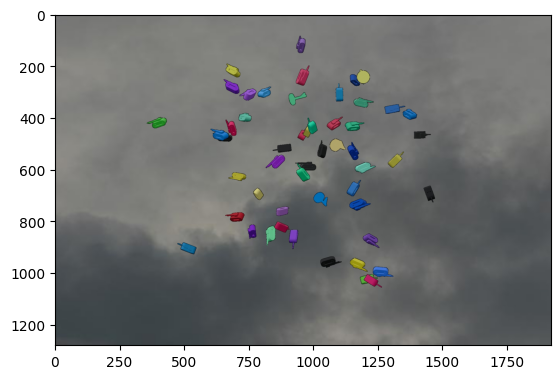

 ---- image with rectangles


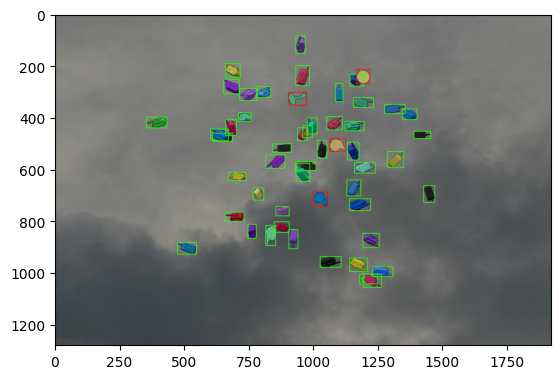

In [12]:
## choose one version of dataset among "real_images", "synthetic_images" and "synthetic_dataset"
path_to_ds = "synthetic_dataset"
idx = 0

img_path = f"{path_to_ds}/images/{str(idx).zfill(6)}.jpg"
lab_path = f"{path_to_ds}/labels/{str(idx).zfill(6)}.txt"

image = cv2.imread(img_path)
assert image is not None, f"img not found at path {img_path}"
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR ) # dear old opencv (imshow wants bgr)

H, W = image.shape[:2]

## not written rule: if label file doesn't exist, then no army is present
image_with_rect = image.copy()
if os.path.exists(lab_path):
    with open(lab_path, "r") as file:
        for line in file:
            line = line.split(" ")
            c, x, y, w, h = int(line[0]), float(line[1]), float(line[2]), float(line[3]), float(line[4])
            x1, y1 = int((x-w/2)*W), int((y-h/2)*H)
            x2, y2 = int((x+w/2)*W), int((y+h/2)*H)
            
            cv2.rectangle(image_with_rect, (x1, y1), (x2, y2), (36,255,12, 1) if c < 6 else (255,12,10, 1), 2)

print(" ---- image without rectangles")
plt.imshow(image)
plt.show()
print(" ---- image with rectangles")
plt.imshow(image_with_rect)
plt.show()

## Creation of the folders that will contain the split dataset
We decided to create three folders:
- train
- validation
- test

Each folder then contains two subfolders:
- real
- synthetic

Each of the two above subfolders then contains two folders:
- images
- labels

In [13]:
# name of the folder containing the datasets (train, validation, test)
datasets_folder = "datasets"

# path from the current position to the folder containing the datasets
datasets_folder_path = os.path.join(os.getcwd(), datasets_folder)

# names of the datasets
datasets_names = ["train", "validation", "test"]

# names of the subfolders of each dataset folder
synthetic_real_names = ["synthetic", "real"]

# names of the subfolders of each of the above subfolder
images_labels_names = ["images", "labels"]

# check if the folders containing the datasets exist, otherwise create them all
if not os.path.isdir(datasets_folder):
    os.mkdir(datasets_folder)
    print(f"created folder {datasets_folder}")

    # paths for the datasets folders inside datasets 
    train_validation_test = []
    # paths for the subfolders of each dataset folder
    synthetic_real = []
    # paths for the subfolders of each subfolder
    images_labels = []

    # create each dataset folder (train, validation, test) with its subfolders (images, labels)
    for name in datasets_names:
        path = os.path.join(datasets_folder_path, name)
        train_validation_test.append(path)
        os.mkdir(path)
        print(f"created folder {path}")
        # for each created dataset folder, create its subfolders (synthetic, real)
        for sub_dir in synthetic_real_names:
            sub_path = os.path.join(path, sub_dir)
            synthetic_real.append(sub_path)
            os.mkdir(sub_path)
            print(f"created folder {sub_path}")
            # for each created subfolder, create its subfolders (images, labels)
            for sub_sub_dir in images_labels_names:
                sub_sub_path = os.path.join(sub_path, sub_sub_dir)
                images_labels.append(sub_sub_path)
                os.mkdir(sub_sub_path)
                print(f"created folder {sub_sub_path}")

created folder datasets
created folder /content/drive/MyDrive/Colab environments/Risiko! DL/datasets/train
created folder /content/drive/MyDrive/Colab environments/Risiko! DL/datasets/train/synthetic
created folder /content/drive/MyDrive/Colab environments/Risiko! DL/datasets/train/synthetic/images
created folder /content/drive/MyDrive/Colab environments/Risiko! DL/datasets/train/synthetic/labels
created folder /content/drive/MyDrive/Colab environments/Risiko! DL/datasets/train/real
created folder /content/drive/MyDrive/Colab environments/Risiko! DL/datasets/train/real/images
created folder /content/drive/MyDrive/Colab environments/Risiko! DL/datasets/train/real/labels
created folder /content/drive/MyDrive/Colab environments/Risiko! DL/datasets/validation
created folder /content/drive/MyDrive/Colab environments/Risiko! DL/datasets/validation/synthetic
created folder /content/drive/MyDrive/Colab environments/Risiko! DL/datasets/validation/synthetic/images
created folder /content/drive/M

## Load the images
We load the images from the three folders:
- synthetic_images
- synthetic_dataset
- real_images

In [14]:
# load images in the synthetic_images folder
synthetic_images = []

synthetic_images_path = os.path.join(os.getcwd(), "synthetic_images", "images")

for file_name in os.listdir(synthetic_images_path):
    if file_name.endswith(".jpg"):
        synthetic_images.append(cv2.imread(os.path.join(synthetic_images_path, file_name)))

# load images in the synthetic_dataset folder
synthetic_dataset = []
synthetic_dataset_path = os.path.join(os.getcwd(), "synthetic_dataset", "images")

for file_name in os.listdir(synthetic_dataset_path):
    if file_name.endswith(".jpg"):
        synthetic_dataset.append(cv2.imread(os.path.join(synthetic_dataset_path, file_name)))

# load images in the real_images folder
real_images = []
real_images_path = os.path.join(os.getcwd(), "real_images", "images")

for file_name in os.listdir(real_images_path):
    if file_name.endswith(".jpg"):
        real_images.append(cv2.imread(os.path.join(real_images_path, file_name)))

## Datasets split into the above folders
- Images and labels from $synthetic\_dataset$ are split into:
    - train 70%
    - validation 15%
    - test 15%
- Images and labels from $synthetic\_images$ are split into:
    - train 70%
    - validation 15%
    - test 15%
- Images and labels from $real\_images$ are split into:
    - train 70%
    - test 30%